# 1.Introduction

The task is to provide insights to the building management about how to maintain the environmental guidance for an office environment. The data is provided in json packets.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from tqdm import tqdm

Load the indoor and outdoor air quality data into dataframes first. From a quick glance the indoor air quality data is from various sensors. Instead of splitting this up into seperate dataframes, I can leave it in the same dataframe and just filter by the sensor id

In [13]:
#read in the json and encode the iso + zulu time information
iaq = pd.read_json("data/iaq.json", convert_dates=["documentTime"])
iaq.head()

,documentTime,temp,humidity,co2,sensor_id
0,2023-01-23 00:03:37+00:00,23.5,22,788,ENKZYW001792
1,2023-01-23 00:00:48+00:00,23.6,23,778,ENKZYW001804
2,2023-01-23 00:04:53+00:00,22.0,25,785,ENKZYW001882
3,2023-01-23 00:01:33+00:00,23.2,47,449,ENKZYW001856
4,2023-01-23 00:04:29+00:00,22.8,23,780,ENKZYW001848


The indoor air quality data will be the primary dataset, so lets do some EDA on it to see what we are working with.

## 2. Exploratory Data Analysis

In [14]:
print(f"{iaq.shape[0]} rows and {iaq.shape[1]} columns in the dataset")

102629 rows and 5 columns in the dataset


In [16]:
iaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102629 entries, 0 to 102628
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   documentTime  102629 non-null  datetime64[ns, UTC]
 1   temp          102629 non-null  float64            
 2   humidity      102629 non-null  int64              
 3   co2           102629 non-null  int64              
 4   sensor_id     102629 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


As expected, in this dataset we're working with ints and floats for the sensor readings, datettime for the read time and strings for the sensor id. It is also good that there is no missing data in this dataset, at least in the sense that no columns have any null values. 

Nulls would only be present if the data recording mechanism fails, but if the sensor itself fails then the expected null values will be swapped out for another constant value. Given the time constraint, I am assuming that all sensors are working and none will reflect any systemic bias in the data.

I am now interested in seeing how many sensors we actually have. Do they all have the same amount of reads?

In [22]:
sensor_counts = iaq.sensor_id.value_counts()

print(f"There are {len(sensor_counts)} sensors in this dataset")
print(sensor_counts)

There are 14 sensors in this dataset
ENKZYW001883    7938
ENKZYW001884    7936
ENKZYW001900    7934
ENKZYW001848    7931
ENKZYW001819    7927
ENKZYW001792    7926
ENKZYW001958    7920
ENKZYW001888    7914
ENKZYW001837    7890
ENKZYW001925    7769
ENKZYW001882    7768
ENKZYW001804    7245
ENKZYW001856    4980
ENKZYW001935    3551
Name: sensor_id, dtype: int64


All sensors in this dataset have a different number of reads. No consequence of this for now, but good to keep in mind when it comes to critique the generated insights.

To get some visual intuition, lets see if I can match the sensors to their location using the other data provided.

100%|██████████| 2/2 [00:00<00:00, 17.22it/s]


<Figure size 640x480 with 0 Axes>

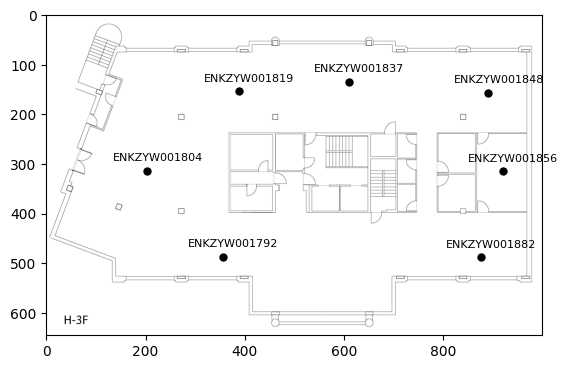

<Figure size 640x480 with 0 Axes>

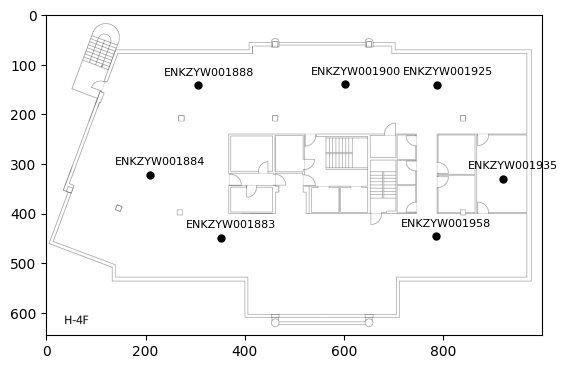

In [51]:
# This time lets read the json in as a dictionary
with open('data/floors.json') as json_file:
    floor_data = json.load(json_file)

#iterate and plot
for packet in tqdm(floor_data):
    
    image_name = packet["image"]["name"]

    #read the image into a enw figure
    plt.figure()
    im = plt.imread(f"data/{image_name}")
    fig, ax = plt.subplots()
    im = ax.imshow(im)

    #the sensors key is a list of more dictionarys
    sensors = packet["sensors"]

    #plot each sensor and annotate. At this point the coordinate system is the image standard i.e mirrored on the x axis
    for sensor in sensors:
        x,y = sensor["location"]["x"],sensor["location"]["y"]
        plt.plot(x,y,'k.',markersize=10)
        ax.annotate(sensor["sensor_id"], (x,y),xytext =(x - 70,y - 20), fontsize =8)

Interesting to see that the sensors are placed vaguely in the same spot on both floors. Also that the sensors are laid out in a ring-like structure. No apparant rhyme or reason to why some sensors have less readings than others though.